In [ ]:
from mixer.models.modeling import MlpMixer, CONFIGS
import numpy as np
from cka_heatmap import compute_heatmap, display_heatmap, cka_linear
from data_loaders import get_imagenet_val_loader
from torch.nn.utils import prune
import torch

In [ ]:
def load_mixer(config, path):
    mixer = MlpMixer(config, num_classes=1000 if '21k' not in path else 21843)
    mixer.load_from(np.load(path))
    return mixer

In [ ]:
mixers = [
    (CONFIGS['Mixer-B_16'], "mixer/checkpoint/gsam/Mixer-B_16.npz"),
    (CONFIGS['Mixer-B_32'], "mixer/checkpoint/gsam/Mixer-B_32.npz"),
    (CONFIGS['Mixer-S_8'], "mixer/checkpoint/gsam/Mixer-S_8.npz"),
    (CONFIGS['Mixer-S_16'], "mixer/checkpoint/gsam/Mixer-S_16.npz"),
    (CONFIGS['Mixer-S_32'], "mixer/checkpoint/gsam/Mixer-S_32.npz"),
    
    (CONFIGS['Mixer-B_16'], "mixer/checkpoint/imagenet1k/Mixer-B_16.npz"),
    (CONFIGS['Mixer-L_16'], "mixer/checkpoint/imagenet1k/Mixer-L_16.npz"),

    (CONFIGS['Mixer-B_16'], "mixer/checkpoint/imagenet21k/Mixer-B_16.npz"),
    (CONFIGS['Mixer-L_16'], "mixer/checkpoint/imagenet21k/Mixer-L_16.npz"),

    (CONFIGS['Mixer-B_16'], "mixer/checkpoint/sam/Mixer-B_16.npz"),
    (CONFIGS['Mixer-B_32'], "mixer/checkpoint/sam/Mixer-B_32.npz"),
]

In [40]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# mixer = mixer.to(device)
        

In [41]:
def get_pruned_mixer(p):
    mixer = load_mixer(CONFIGS['Mixer-B_16'], "mixer/checkpoint/imagenet1k/Mixer-B_16.npz")

    parameters_to_prune = []
    for layer in mixer.layer:
        parameters_to_prune.append((layer.token_mlp_block.fc0, 'weight'))
        parameters_to_prune.append((layer.token_mlp_block.fc1, 'weight'))
        parameters_to_prune.append((layer.channel_mlp_block.fc0, 'weight'))
        parameters_to_prune.append((layer.channel_mlp_block.fc1, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=p,
    )
    return mixer

tensor(0.7391, device='cuda:0')


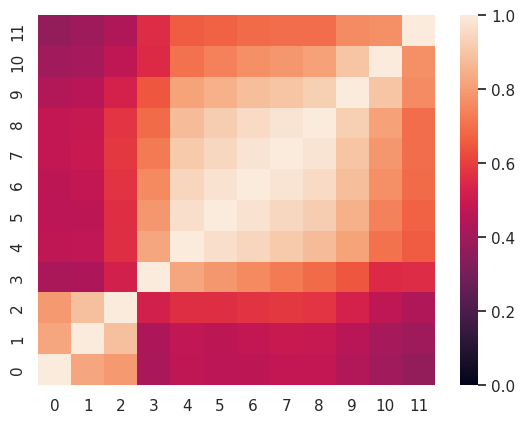

tensor(0.7398, device='cuda:0')


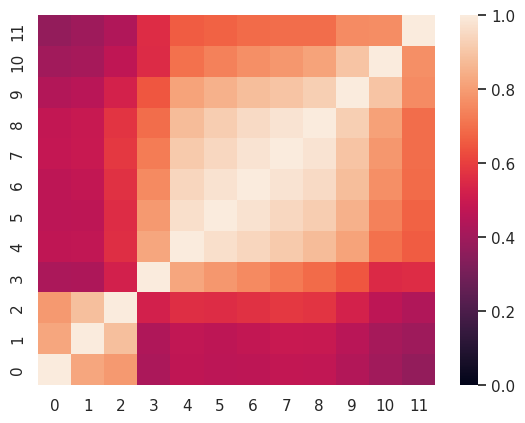

tensor(0.7359, device='cuda:0')


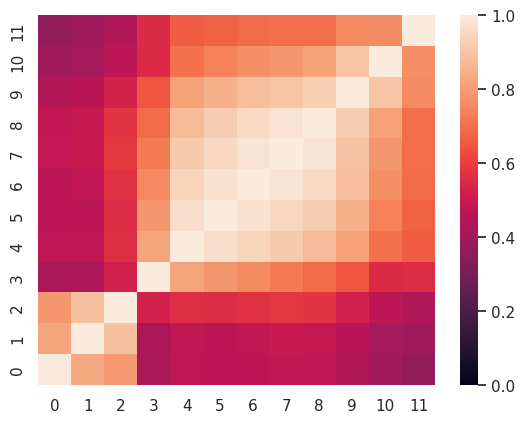

tensor(0.7044, device='cuda:0')


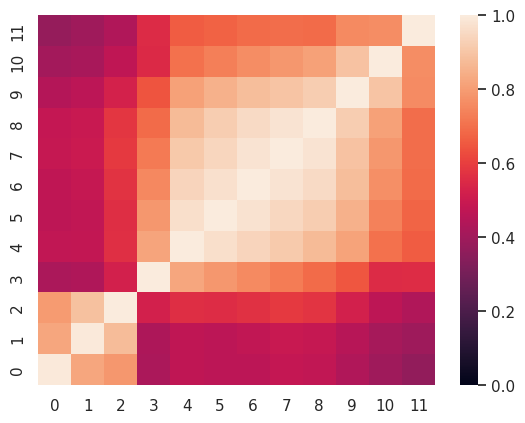

tensor(0.5339, device='cuda:0')


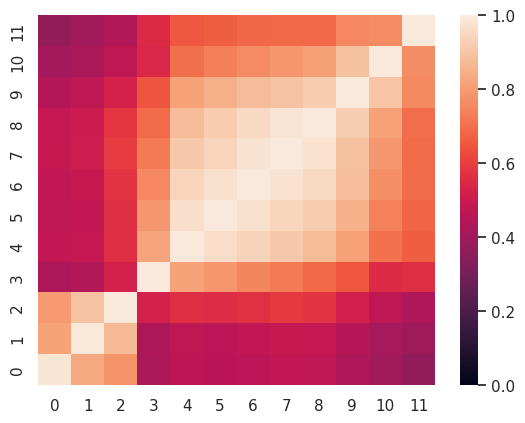

tensor(0.0203, device='cuda:0')


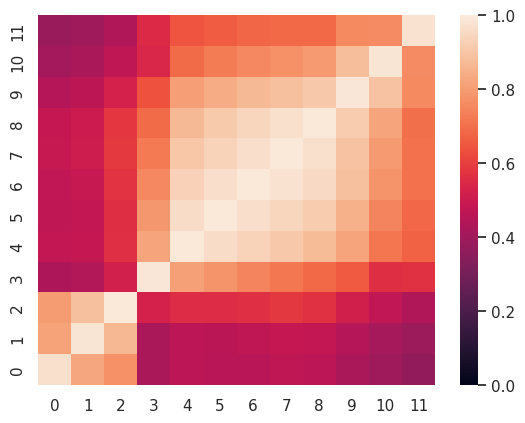

tensor(0.0011, device='cuda:0')


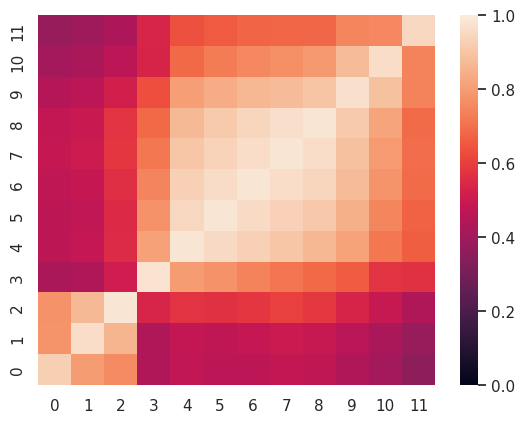

tensor(0.0009, device='cuda:0')


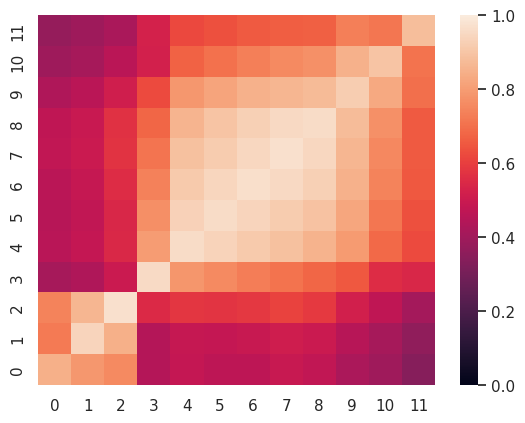

tensor(0.0007, device='cuda:0')


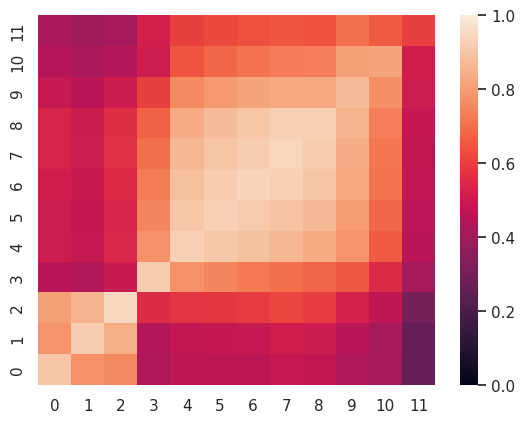

tensor(0.0010, device='cuda:0')


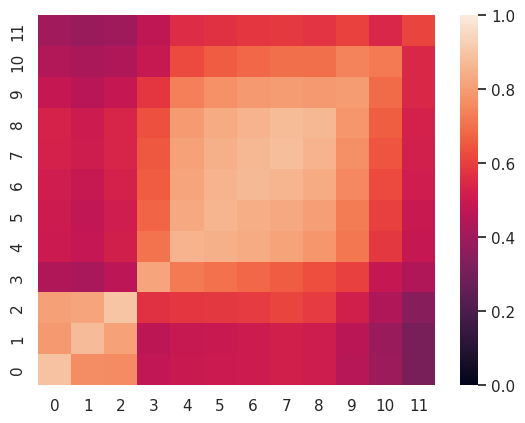

In [47]:
from cka_heatmap import compute_heatmap, display_heatmap
from data_loaders import get_imagenet_test_loader

loader = get_imagenet_test_loader(64)

mixer_org = load_mixer(CONFIGS['Mixer-B_16'], "mixer/checkpoint/imagenet1k/Mixer-B_16.npz")

def get_activation_hook(act, idx):
    def hook(model, input, output):
        act[idx] = output.detach().numpy()
    return hook


def add_hooks(mixer):
    act = [None for _ in mixer.layer]
    for i, layer in enumerate(mixer.layer):
        layer.register_forward_hook(get_activation_hook(act, i))
    return act


def get_activations(mixer, data):
    act = add_hooks(mixer)
    _ = mixer(data)
    return act


data = next(iter(loader))[0]
for p in (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9):
    mixer = get_pruned_mixer(p)
    print(compute_acc(mixer))
    act_prune = get_activations(mixer, data)
    act = get_activations(mixer_org, data)
    heatmap = compute_heatmap(act, act_prune)
    display_heatmap(heatmap)

In [45]:
def compute_acc(mixer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    mixer = mixer.to(device)
    mixer.eval()

    loader = get_imagenet_val_loader(64)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred_y = torch.argmax(mixer(batch_x), axis=-1)
            correct += torch.sum(torch.eq(batch_y, pred_y))
            total += batch_y.shape[0]
    
    mixer = mixer.to("cpu")
    return correct / total